In [12]:
import numpy as np # linear algebra
import pandas as pd
import datetime# data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [13]:
train_data = pd.read_csv('C:/Users/hp/Documents/tps_mar22_train.csv', index_col = 'row_id')
train_data.head()

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60


In [14]:
def preprocess(df):
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df['weekday'] = df['time'].dt.dayofweek
    df['is_weekend'] = df['weekday'] > 4
    df.drop('time', axis = 1, inplace = True)
    df.direction = df.direction.astype('category').cat.codes
    df.is_weekend = df.is_weekend.astype('category').cat.codes
    
#     df.drop('time', axis = 1, inplace = True)
#     weekday_series = df['weekday']
#     weekday_series[weekday_series < 5] = 0
#     weekday_series[weekday_series > 4] = 1
#     df['is_weekend'] = weekday_series

In [15]:
preprocess(train_data)
train_data.head()

,x,y,direction,congestion,year,month,day,hour,minute,weekday,is_weekend
row_id,,,,,,,,,,,
0,0,0,0,70,1991,4,1,0,0,0,0
1,0,0,1,49,1991,4,1,0,0,0,0
2,0,0,4,24,1991,4,1,0,0,0,0
3,0,1,0,18,1991,4,1,0,0,0,0
4,0,1,1,60,1991,4,1,0,0,0,0


In [16]:
train_data['weekday'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [17]:
train_data['is_weekend'].unique()

array([0, 1], dtype=int8)

Text(0.5, 1.0, 'Distribution of congestion')

<Figure size 1000x600 with 0 Axes>

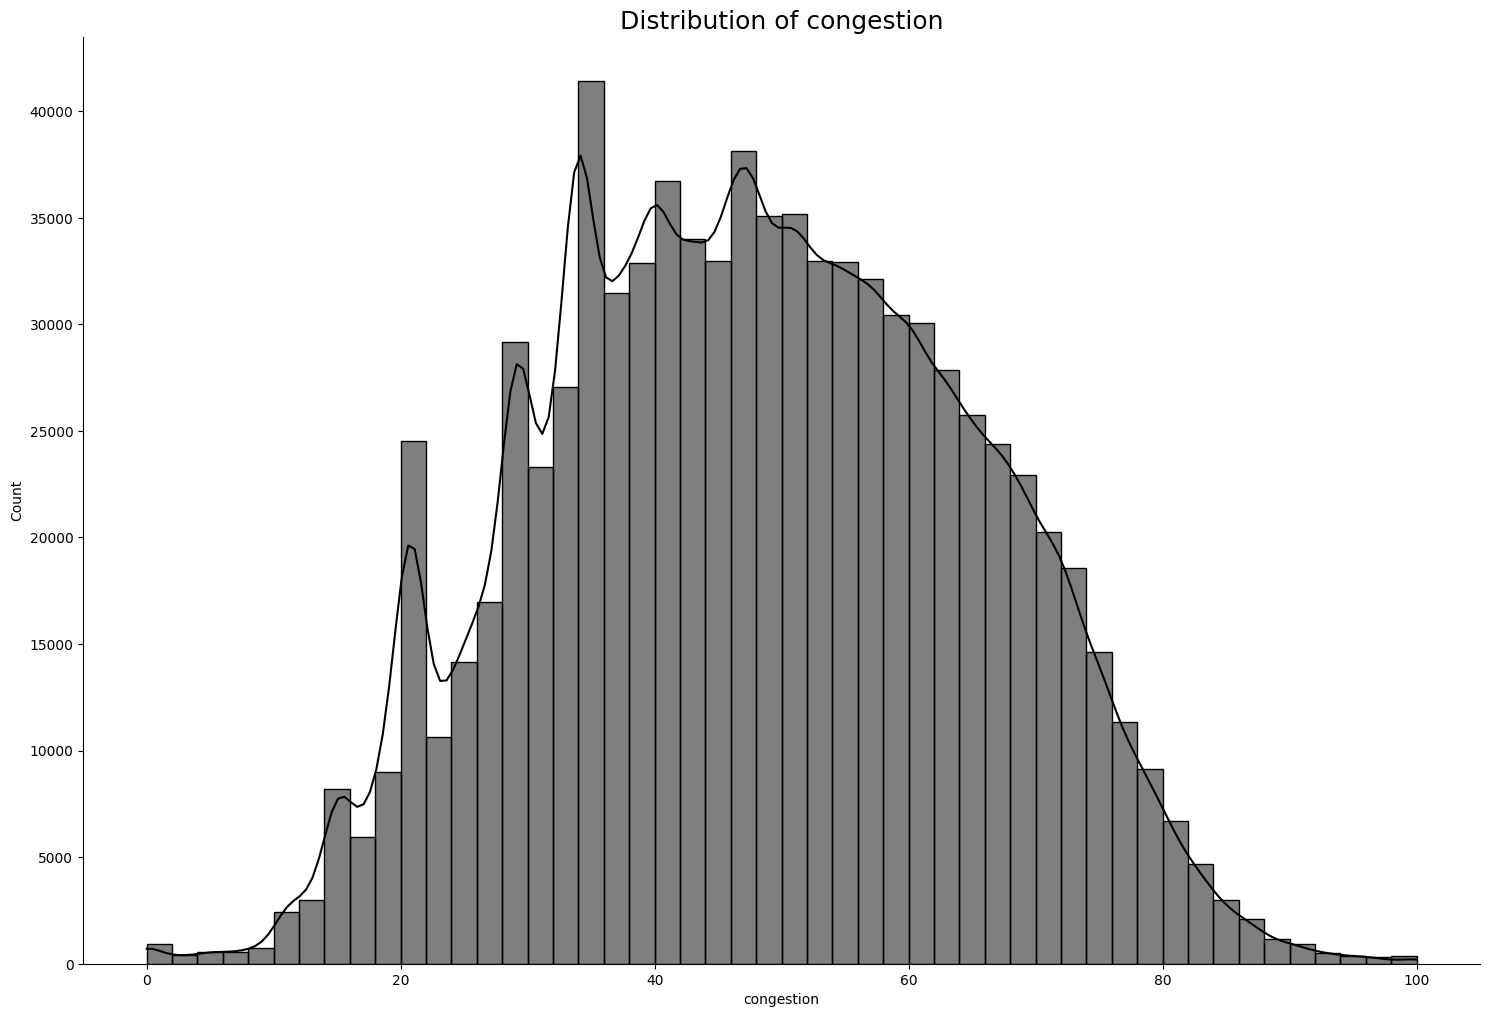

In [18]:
plt.figure(figsize = (10, 6))
sns.displot(x = 'congestion', data = train_data, bins = 50, kde = True, height = 10, aspect = 1.5, color = 'Black')
plt.title('Distribution of congestion', fontsize = 18)

In [19]:
train_data.isnull().sum()

x             0
y             0
direction     0
congestion    0
year          0
month         0
day           0
hour          0
minute        0
weekday       0
is_weekend    0
dtype: int64

In [20]:
def box_plot(col_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (14, 10))
    sns.boxplot(ax = axes[0], x = col_name , y = 'congestion', data = train_data, 
                width = 1, palette = 'magma')
    axes[0].ticklabel_format(style = 'plain', axis = 'y')
    axes[0].set_title((col_name + ' vs congestion'), fontsize = 16)

    sns.countplot(ax = axes[1], x = col_name , data = train_data, palette = 'magma')
    axes[1].set_title((col_name + ' Count'), fontsize = 16)
    plt.subplots_adjust(hspace = 0.4)

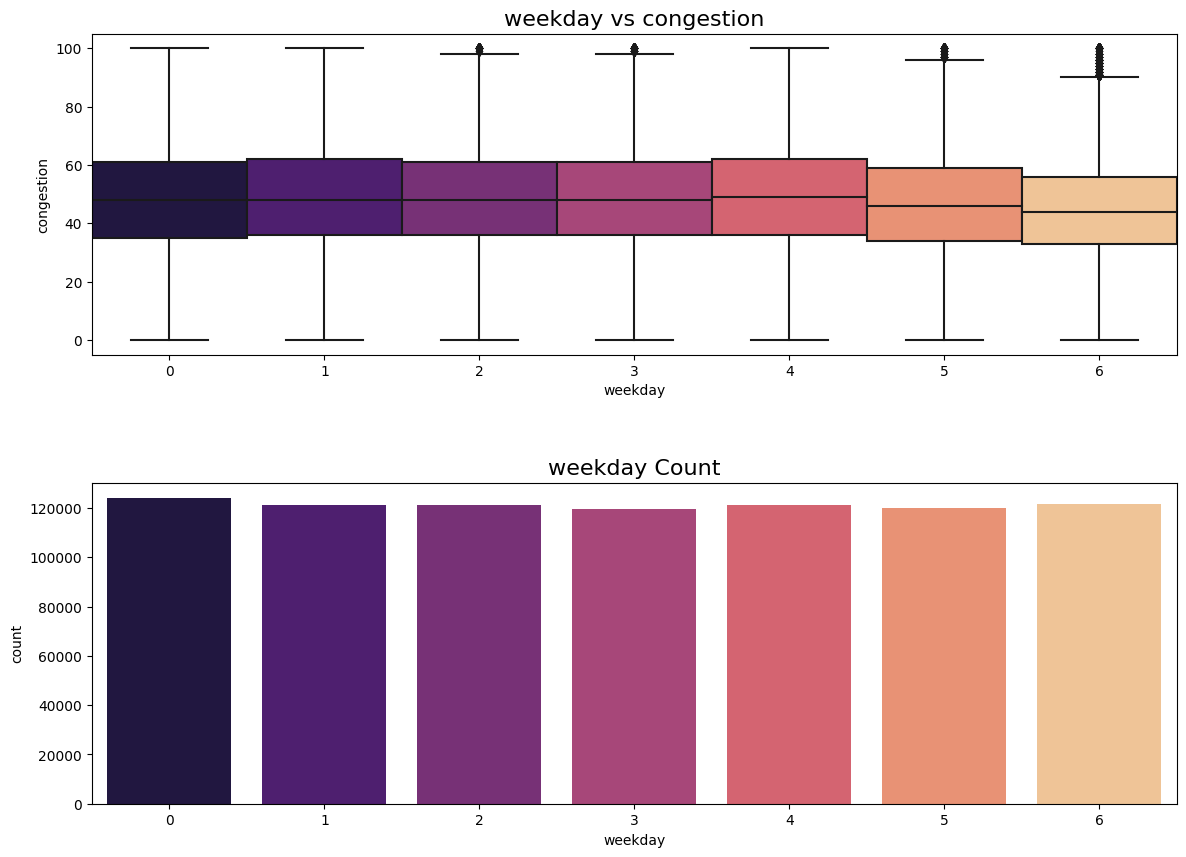

In [21]:
box_plot('weekday')

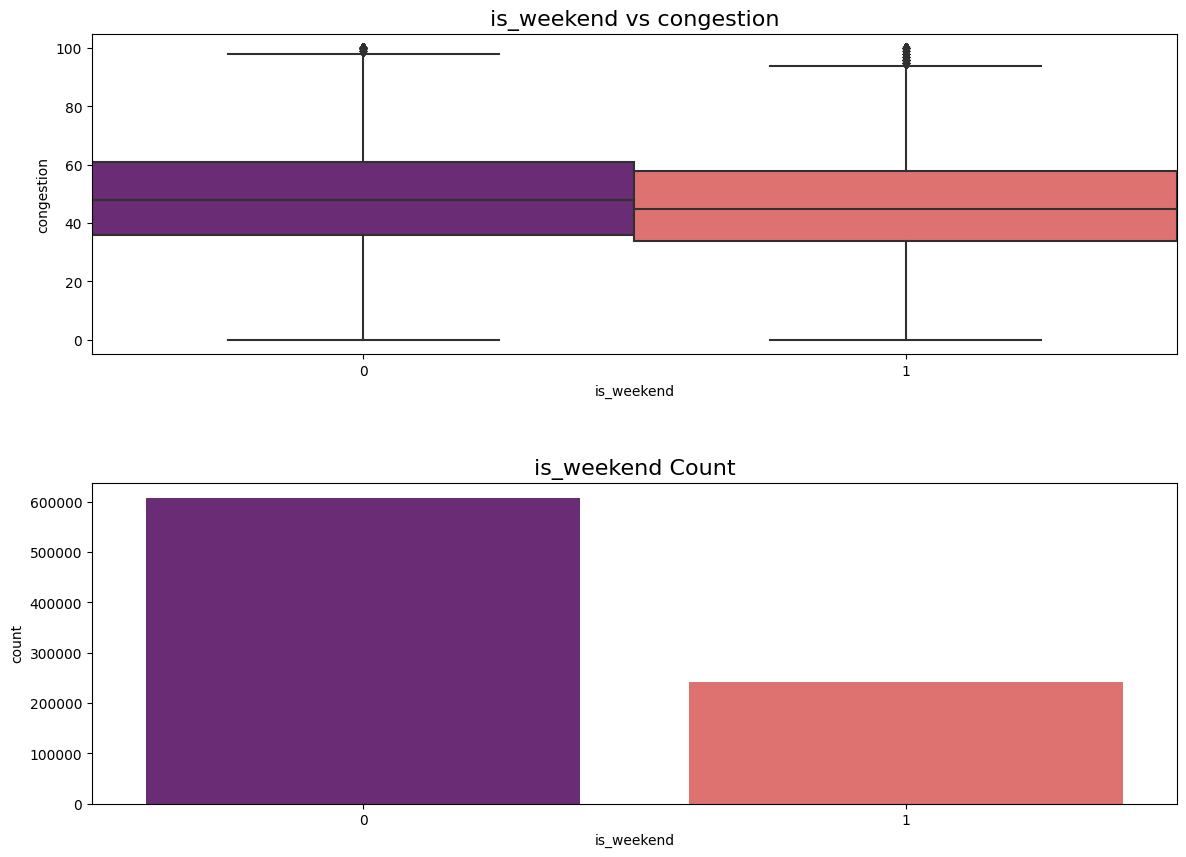

In [22]:
box_plot('is_weekend')

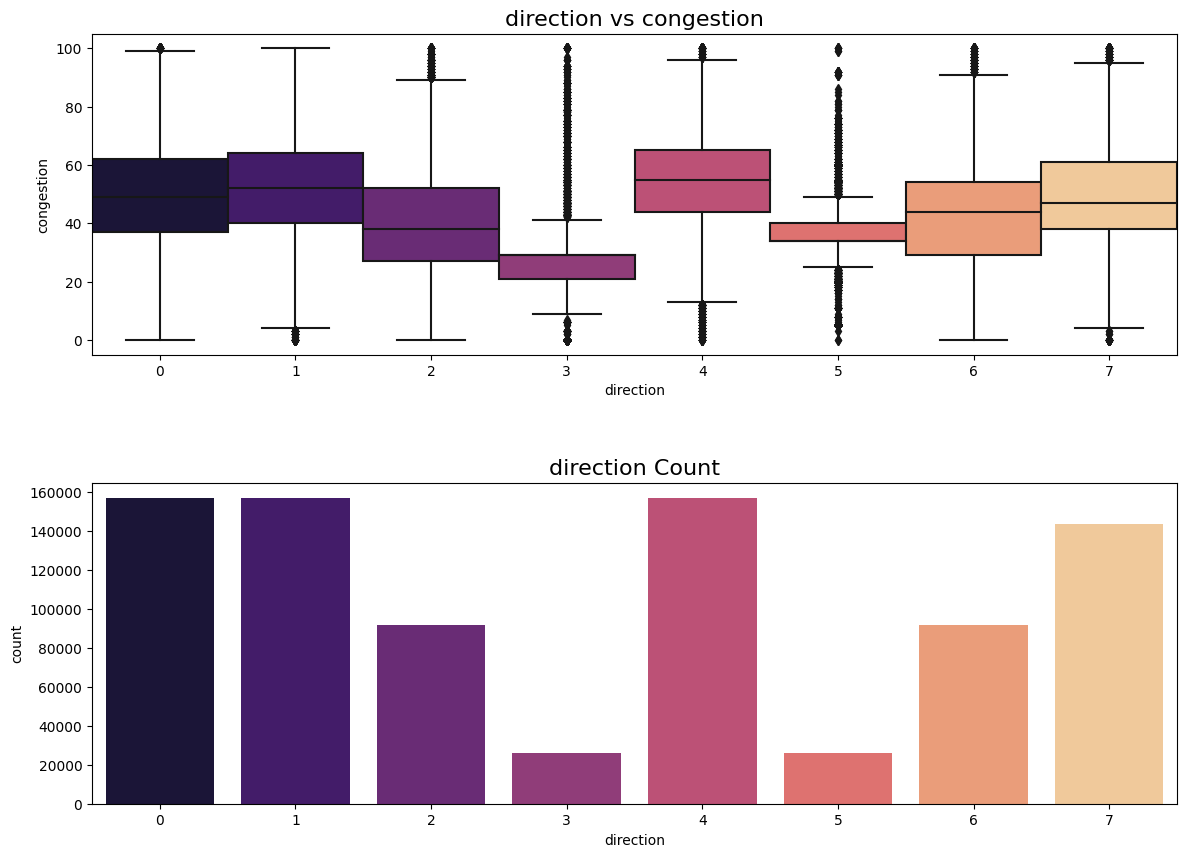

In [23]:
box_plot('direction')

In [24]:
train_data.loc[train_data['direction'] == 3,  'is_weekend'].value_counts()

0    18684
1     7434
Name: is_weekend, dtype: int64

In [25]:
train_data.loc[train_data['direction'] == 5, 'is_weekend'].value_counts()

0    18684
1     7434
Name: is_weekend, dtype: int64

In [26]:
abc = train_data.loc[train_data['direction'] == 3, ['direction', 'is_weekend', 'congestion']]
abc

,direction,is_weekend,congestion
row_id,,,
46,3,0,29
54,3,0,21
111,3,0,29
119,3,0,21
176,3,0,29
...,...,...,...
848694,3,0,21
848751,3,0,29
848759,3,0,22


In [27]:
for i in range(8):
    cond1 = train_data['direction']==i
    cond2 = train_data['congestion']>40
    print(f'Day{i}')
    print(train_data.loc[(cond1&cond2),'is_weekend'].value_counts())

Day0
0    80259
1    28712
Name: is_weekend, dtype: int64
Day1
0    84659
1    30482
Name: is_weekend, dtype: int64
Day2
0    30604
1    10299
Name: is_weekend, dtype: int64
Day3
0    1771
1     325
Name: is_weekend, dtype: int64
Day4
0    91676
1    34198
Name: is_weekend, dtype: int64
Day5
0    3263
1     961
Name: is_weekend, dtype: int64
Day6
0    37120
1    14079
Name: is_weekend, dtype: int64
Day7
0    72182
1    25139
Name: is_weekend, dtype: int64


In [28]:
for i in range(8):
    cond1 = train_data['direction']==i
    cond2 = train_data['congestion']>47
    print(f'Day{i}')
    print(train_data.loc[(cond1&cond2),'is_weekend'].value_counts())

Day0
0    63598
1    21656
Name: is_weekend, dtype: int64
Day1
0    69440
1    24701
Name: is_weekend, dtype: int64
Day2
0    22682
1     7224
Name: is_weekend, dtype: int64
Day3
0    1141
1     246
Name: is_weekend, dtype: int64
Day4
0    77897
1    27336
Name: is_weekend, dtype: int64
Day5
0    1927
1     614
Name: is_weekend, dtype: int64
Day6
0    25396
1    10189
Name: is_weekend, dtype: int64
Day7
0    51846
1    17792
Name: is_weekend, dtype: int64


In [29]:
cri1 = train_data['congestion'] > 45
cri2 = train_data['direction'] == 3
cri3 = train_data['congestion'] < 10
drop1 = train_data.loc[(cri1 & cri2)].index
drop1

Int64Index([  1541,   3036,   3166,   3434,   3499,   7911,   8106,   8691,
             10909,  12526,
            ...
            843819, 843876, 843884, 843941, 843949, 844006, 844014, 844071,
            844079, 844136],
           dtype='int64', name='row_id', length=1609)

In [30]:
drop2 = train_data.loc[(cri2 & cri3)].index
drop2

Int64Index([  1801,   3946,   7456,   9991,  10056,  10121,  10186,  10251,
             10316,  10381,
            ...
            818396, 825351, 825481, 826781, 839391, 840886, 840951, 841081,
            845111, 847971],
           dtype='int64', name='row_id', length=660)

In [31]:
train_data.drop(index = drop1, axis = 0 , inplace = True)

In [32]:
train_data.drop(index = drop2, axis = 0, inplace = True)

In [33]:
cri1 = train_data['congestion'] > 45
cri2 = train_data['direction'] == 5
cri3 = train_data['congestion'] < 25
drop3 = train_data.loc[((cri1 & cri2) | (cri2 & cri3))].index
drop3

Int64Index([    56,    121,    186,    251,    316,    381,    446,    511,
               576,    641,
            ...
            848046, 848111, 848233, 848241, 848306, 848566, 848623, 848631,
            848761, 848818],
           dtype='int64', name='row_id', length=7899)

In [34]:
train_data.drop(index = drop3, axis = 0, inplace = True)

In [35]:
cri4 = train_data['congestion'] > 87
cri5 = train_data['direction'] == 0 
cri6 = train_data['direction'] == 2
cri7 = train_data['direction'] == 4
cri8 = train_data['direction'] == 6
cri9 = train_data['direction'] == 7
cri10 = train_data['congestion'] < 10

In [36]:
drop4 = train_data.loc[((cri4 & cri5) | (cri4 & cri6) | (cri4 & cri7) | (cri4 & cri8) | (cri4 & cri9))].index
drop4

Int64Index([   136,    417,    441,    487,   3438,   3444,   3503,   3813,
              3902,   4981,
            ...
            841586, 842132, 842150, 842197, 842634, 842748, 843554, 845693,
            847313, 848569],
           dtype='int64', name='row_id', length=2945)

In [37]:
train_data.drop(index = drop4, axis = 0, inplace = True)

In [38]:
drop5 = train_data.loc[((cri10 & cri5) | (cri10 & cri6) | (cri10 & cri7) | (cri10 & cri8) | (cri10 & cri9))].index
drop5

Int64Index([   277,    405,    470,    600,    663,    756,    783,    791,
               830,   2533,
            ...
            846402, 846467, 846532, 846563, 846597, 846662, 846727, 846792,
            847095, 847213],
           dtype='int64', name='row_id', length=1932)

In [39]:
train_data.drop(index = drop5, axis = 0, inplace = True)

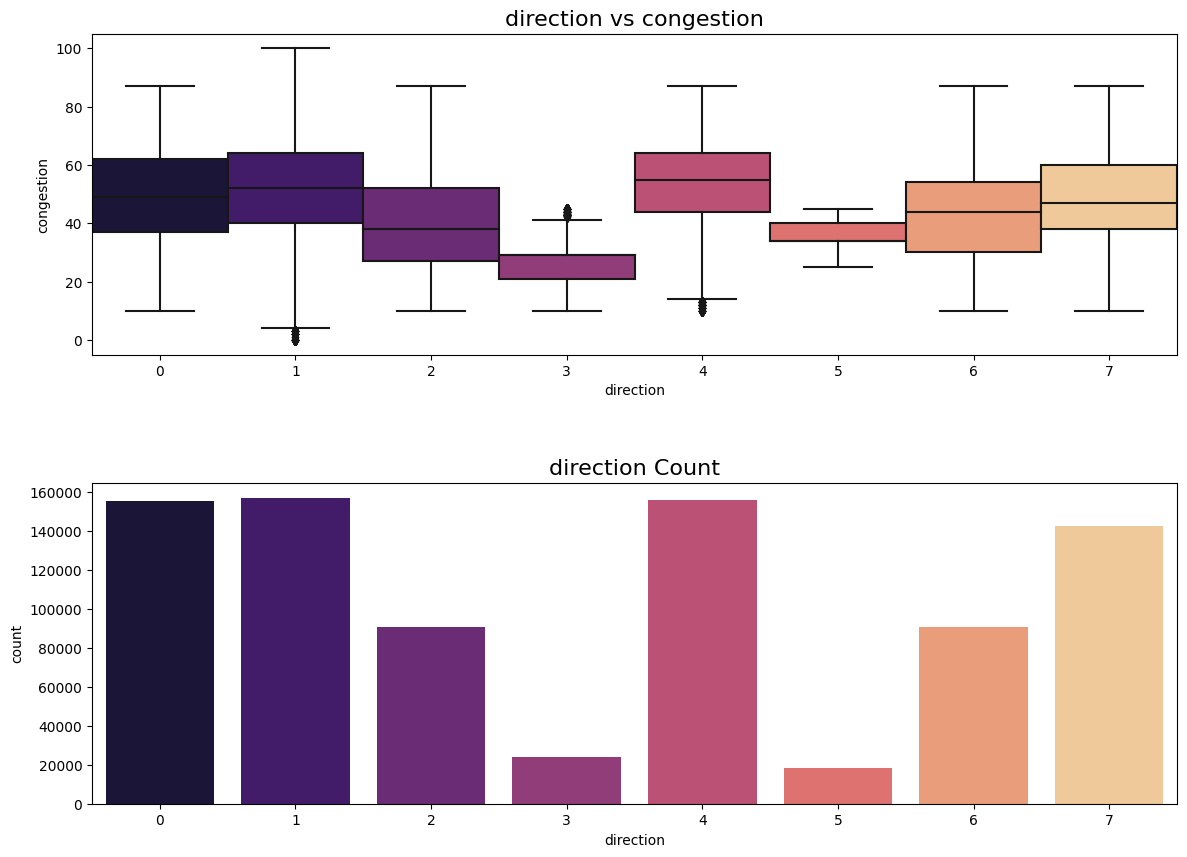

In [40]:
box_plot('direction')

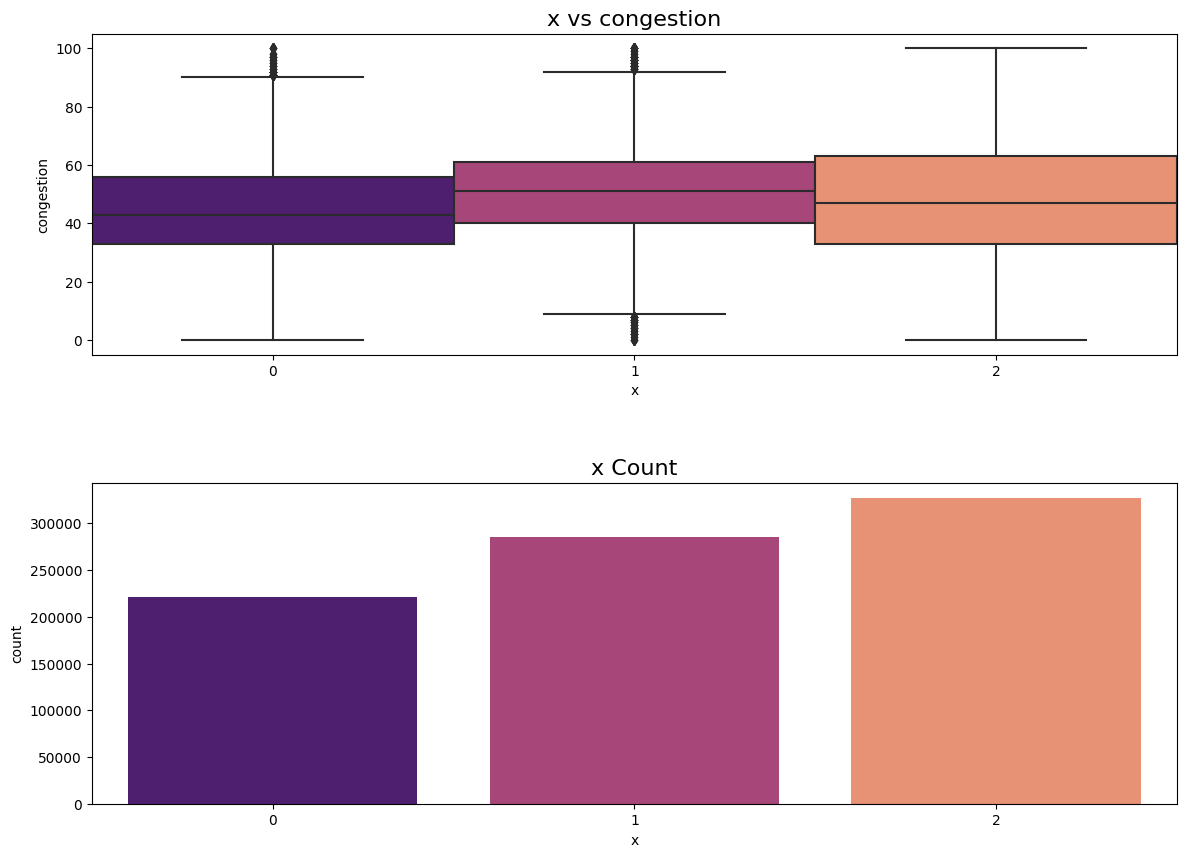

In [41]:
box_plot('x')

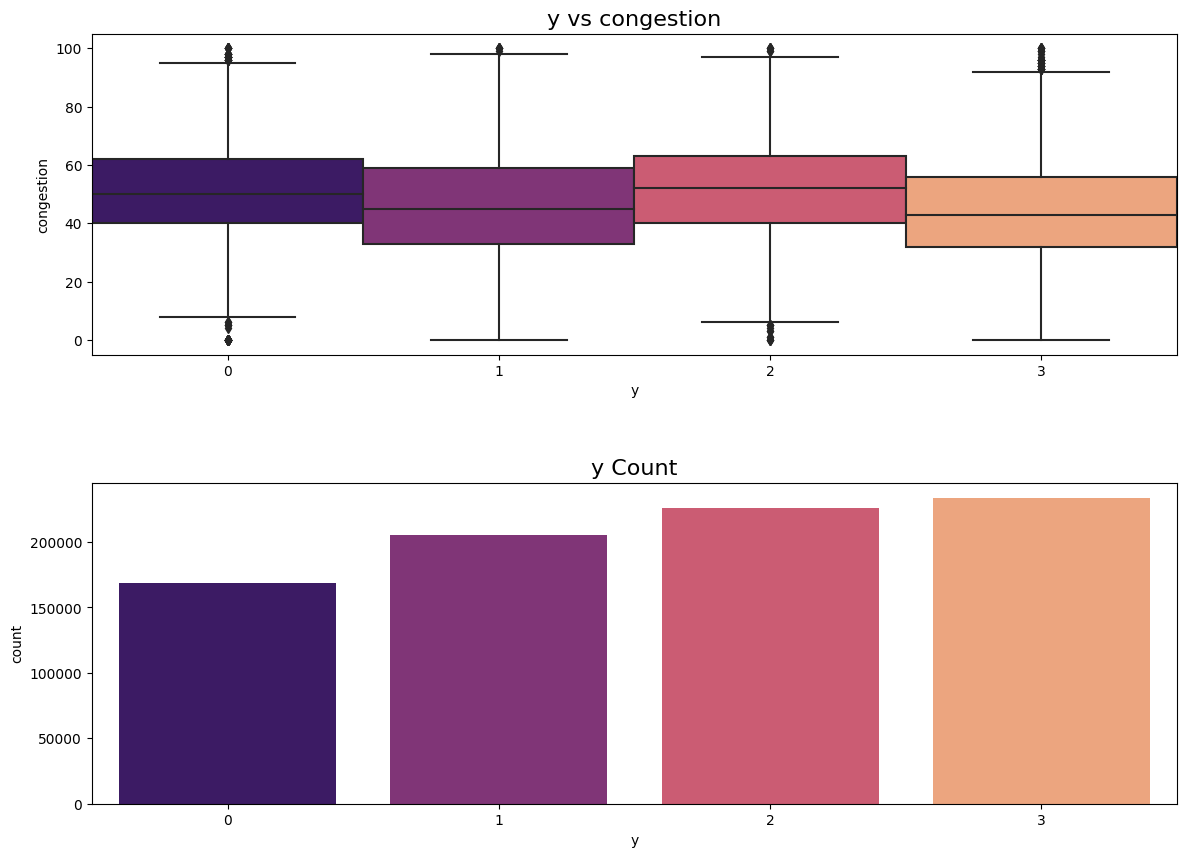

In [42]:
box_plot('y')

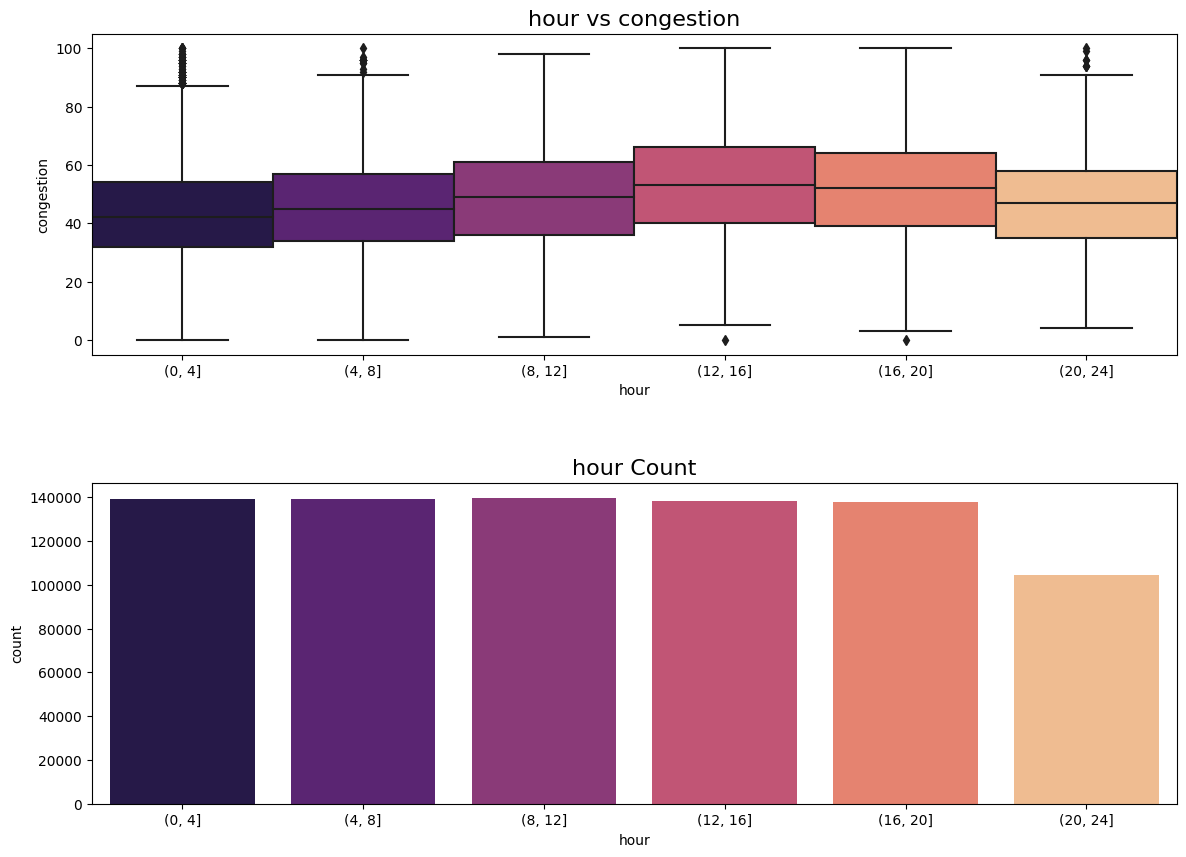

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (14, 10))
sns.boxplot(ax = axes[0], x = pd.cut(train_data['hour'], [0, 4, 8, 12, 16, 20, 24]) , y = 'congestion', data = train_data, 
            width = 1, palette = 'magma')
axes[0].ticklabel_format(style = 'plain', axis = 'y')
axes[0].set_title('hour vs congestion', fontsize = 16)

sns.countplot(ax = axes[1], x = pd.cut(train_data['hour'], [0, 4, 8, 12, 16, 20, 24]) , 
              data = train_data, palette = 'magma')
axes[1].set_title(('hour Count'), fontsize = 16)
plt.subplots_adjust(hspace = 0.4)

In [44]:
criteria1 = train_data['hour'] >= 0
criteria2 = train_data['hour'] <= 8
criteria3 = train_data['congestion'] > 85

In [45]:
a = train_data[criteria1 & criteria2 & criteria3].index
a

Int64Index([   402,    609,   4783,   4826,   5005,   5070,   5135,   5200,
              5265,   5278,
            ...
            833167, 833232, 833908, 834114, 837327, 837572, 842007, 843282,
            847088, 847378],
           dtype='int64', name='row_id', length=732)

In [46]:
train_data.drop(index = a, axis = 0 , inplace = True)

In [47]:
train_data.head(140)

,x,y,direction,congestion,year,month,day,hour,minute,weekday,is_weekend
row_id,,,,,,,,,,,
0,0,0,0,70,1991,4,1,0,0,0,0
1,0,0,1,49,1991,4,1,0,0,0,0
2,0,0,4,24,1991,4,1,0,0,0,0
3,0,1,0,18,1991,4,1,0,0,0,0
4,0,1,1,60,1991,4,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
138,0,2,1,41,1991,4,1,0,40,0,0
139,0,2,4,35,1991,4,1,0,40,0,0
140,0,2,7,35,1991,4,1,0,40,0,0


In [48]:
X = train_data.drop('congestion', axis = 1)
y = train_data['congestion']

In [49]:
def kfolds(m_name):
    kf = KFold(n_splits = 5, shuffle = True, random_state = 70)

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
        print(f'--------fold:{fold+1}--------')
        fold+=1
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

        params = {
            'loss_function' : 'MAPE',
            'task_type' : 'GPU', 
            'grow_policy' : 'SymmetricTree',
            'learning_rate': 0.1,
            'l2_leaf_reg' : 0.2,
            'random_state': 0
         }

        m_name.fit(tr_x,
                  tr_y)

        val_pred = m_name.predict(va_x)

        print(f' MAE: {mean_absolute_error(va_y, val_pred)}')

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train , X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

In [52]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [53]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [54]:
model1.score(X_train, y_train)

0.04255099005996443

In [55]:
model1.score(X_val, y_val)

0.04250765324614636

In [56]:
model2 = Lasso(1)
model2.fit(X_train, y_train)

Lasso(alpha=1)

In [57]:
model2.score(X_train, y_train), model2.score(X_val, y_val)

(0.0319437318728677, 0.031719584267283274)

In [58]:
from sklearn.tree import DecisionTreeRegressor

In [59]:
model3 = DecisionTreeRegressor(max_depth = 10)
model3.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [60]:
model3.score(X_train, y_train), model3.score(X_val, y_val)

(0.7085620728553865, 0.7053815602972707)

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
model4 = RandomForestRegressor(max_depth = 13)
model4.fit(X_train, y_train)

RandomForestRegressor(max_depth=13)

In [63]:
model4.score(X_train, y_train), model4.score(X_val, y_val)

(0.7642773596286982, 0.7463717640815837)

In [64]:
kfolds(model4)

--------fold:1--------
 MAE: 5.900405313819965
--------fold:2--------
 MAE: 5.872650966751186
--------fold:3--------
 MAE: 5.8998248719673025
--------fold:4--------
 MAE: 5.889393409019383
--------fold:5--------
 MAE: 5.862598290171109


In [65]:
model4.feature_importances_

array([0.2323908 , 0.22272789, 0.35934068, 0.        , 0.00961511,
       0.01255399, 0.12419381, 0.00744046, 0.02321957, 0.0085177 ])

In [66]:
feature_importance = pd.DataFrame({'Importance':model4.feature_importances_}, index = X.columns).sort_values('Importance')

In [67]:
feature_importance

,Importance
year,0.000000
minute,0.007440
is_weekend,0.008518
month,0.009615
day,0.012554
weekday,0.023220
hour,0.124194
y,0.222728
x,0.232391
direction,0.359341


In [68]:
feature_importance = feature_importance[feature_importance.Importance > 0.01]
feature_importance

,Importance
day,0.012554
weekday,0.023220
hour,0.124194
y,0.222728
x,0.232391
direction,0.359341


In [69]:
X1 = X[feature_importance.index]
X1

,day,weekday,hour,y,x,direction
row_id,,,,,,
0,1,0,0,0,0,0
1,1,0,0,0,0,1
2,1,0,0,0,0,4
3,1,0,0,1,0,0
4,1,0,0,1,0,1
...,...,...,...,...,...,...
848830,30,0,11,3,2,1
848831,30,0,11,3,2,2
848832,30,0,11,3,2,4


In [70]:
y1 = y
y1

row_id
0         70
1         49
2         24
3         18
4         60
          ..
848830    54
848831    28
848832    68
848833    17
848834    24
Name: congestion, Length: 833058, dtype: int64

In [71]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y)

In [72]:
model7 = RandomForestRegressor(max_depth = 14)
model7.fit(X1_train, y1_train)
model7.score(X1_train, y1_train), model7.score(X1_val, y1_val)

(0.7633708406840282, 0.7420872771750412)

In [73]:
kfolds(model7)

--------fold:1--------
 MAE: 5.802903264192362
--------fold:2--------
 MAE: 5.779620124510147
--------fold:3--------
 MAE: 5.811030509113284
--------fold:4--------
 MAE: 5.79518160114752
--------fold:5--------
 MAE: 5.771807530504667


In [75]:
from xgboost import XGBRegressor

In [76]:
model5 = XGBRegressor(max_depth = 15, learning_rate = 0.07)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [77]:
model5.score(X_train, y_train), model5.score(X_val, y_val)

(0.8690001443089987, 0.7724369368382965)

In [78]:
kfolds(model5)

--------fold:1--------
 MAE: 5.5313536168787545
--------fold:2--------
 MAE: 5.508619125363372
--------fold:3--------
 MAE: 5.53794562488639
--------fold:4--------
 MAE: 5.510677413314343
--------fold:5--------
 MAE: 5.510237740064819


In [79]:
model6 = CatBoostRegressor(logging_level = 'Silent', depth = 12,
                                  eval_metric = 'MAE', loss_function = 'MAE', n_estimators = 1200, task_type = 'GPU')

In [ ]:
#model6.score(X_train, y_train), model6.score(X_val, y_val)

In [80]:
kfolds(model6)

--------fold:1--------


Default metric period is 5 because MAE is/are not implemented for GPU


 MAE: 7.935777185981659
--------fold:2--------


Default metric period is 5 because MAE is/are not implemented for GPU


 MAE: 7.9304795339144984
--------fold:3--------


Default metric period is 5 because MAE is/are not implemented for GPU


 MAE: 7.933822551835025
--------fold:4--------


Default metric period is 5 because MAE is/are not implemented for GPU


 MAE: 7.923000159960241
--------fold:5--------


Default metric period is 5 because MAE is/are not implemented for GPU


 MAE: 7.9072921363766975


In [81]:
test_data = pd.read_csv('C:/Users/hp/Documents/tps_mar22_test.csv', index_col = 'row_id')

In [82]:
preprocess(test_data)
test_data.head()

,x,y,direction,year,month,day,hour,minute,weekday,is_weekend
row_id,,,,,,,,,,
848835,0,0,0,1991,9,30,12,0,0,0
848836,0,0,1,1991,9,30,12,0,0,0
848837,0,0,4,1991,9,30,12,0,0,0
848838,0,1,0,1991,9,30,12,0,0,0
848839,0,1,1,1991,9,30,12,0,0,0


In [83]:
y_pred = model5.predict(test_data)
y_pred

array([44.35691 , 42.81035 , 56.772896, ..., 68.95638 , 19.91034 ,
       42.97613 ], dtype=float32)

In [84]:
sub_csv = pd.read_csv('C:/Users/hp/Documents/tps_mar22_sample_submission.csv', index_col = 'row_id')
sub_csv.head()

,congestion
row_id,
848835,0.0
848836,0.0
848837,0.0
848838,0.0
848839,0.0


In [85]:
sub_csv['congestion'] = y_pred
sub_csv.head()

,congestion
row_id,
848835,44.356911
848836,42.810349
848837,56.772896
848838,22.549879
848839,71.256714


In [86]:
sub_csv.to_csv('submission7.csv')